In [11]:
import numpy as np
import pandas as pd
import sys
import os
sys.path.append('../')
from genetic_algorithm import GA_functions as GA
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
import scipy

This notebook will be used to fit the experimental data of an assembly of tubes-like sturtcures with different diameters. 

The simulated scattering curves of the tube-like models are first loaded

In [42]:
filenames = os.listdir('../Data/Simulated_Scattering_Data/')
filenames

['SAXS_RhuA_82.npy',
 'SAXS_RhuA_82_Assembly_13_40OD_30ID_1200long.npy',
 'SAXS_RhuA_82_Assembly_15_44OD_34ID_1200long.npy',
 'SAXS_RhuA_82_Assembly_17_48OD_38ID_1200long.npy',
 'SAXS_RhuA_82_Assembly_19_52OD_42ID_1200long.npy',
 'SAXS_RhuA_82_Assembly_21_58OD_48ID_1200long.npy',
 'SAXS_RhuA_82_Assembly_23_66OD_56ID_1200long.npy',
 'SAXS_RhuA_82_Assembly_25_70OD_60ID_1200long.npy',
 'SAXS_RhuA_82_Assembly_27_74OD_64ID_1200long.npy',
 'SAXS_RhuA_82_Assembly_29_78OD_68ID_1200long.npy']

In [13]:
model0 = np.load('../Data/Simulated_Scattering_Data/' + filenames[0])
model1 = np.load('../Data/Simulated_Scattering_Data/' + filenames[1])
model2 = np.load('../Data/Simulated_Scattering_Data/' + filenames[2])
model3 = np.load('../Data/Simulated_Scattering_Data/' + filenames[3])
model4 = np.load('../Data/Simulated_Scattering_Data/' + filenames[4])
model5 = np.load('../Data/Simulated_Scattering_Data/' + filenames[5])
model6 = np.load('../Data/Simulated_Scattering_Data/' + filenames[6])
model7 = np.load('../Data/Simulated_Scattering_Data/' + filenames[7])
model8 = np.load('../Data/Simulated_Scattering_Data/' + filenames[8])
model9 = np.load('../Data/Simulated_Scattering_Data/' + filenames[9])

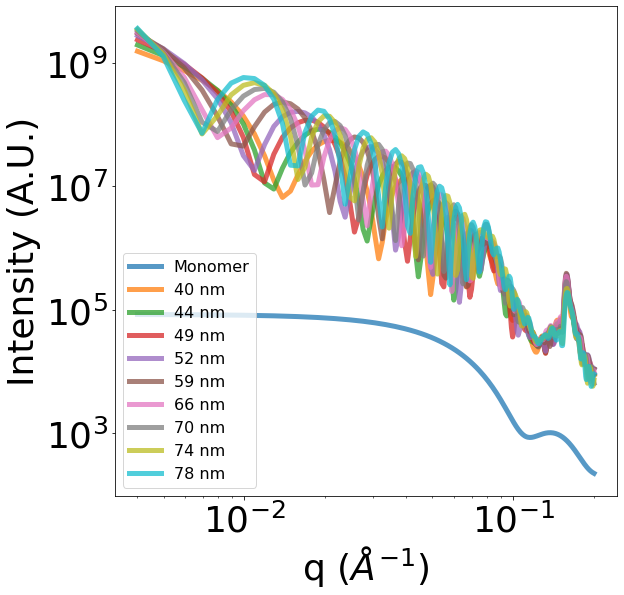

In [51]:
plt.rcParams.update({'font.size': 36})
plt.subplots(figsize=(9,9))
background = 9*10e-6
scale = 0.1
plt.loglog(model0[:,0], model0[:,1], linewidth = 5, alpha = 0.75, label = 'Monomer')
plt.loglog(model1[:,0], model1[:,1], linewidth = 5, alpha = 0.75, label = '40 nm')
plt.loglog(model2[:,0], model2[:,1], linewidth = 5, alpha = 0.75, label = '44 nm')
plt.loglog(model3[:,0], model3[:,1], linewidth = 5, alpha = 0.75, label = '49 nm')
plt.loglog(model4[:,0], model4[:,1], linewidth = 5, alpha = 0.75, label = '52 nm')
plt.loglog(model5[:,0], model5[:,1], linewidth = 5, alpha = 0.75, label = '59 nm')
plt.loglog(model6[:,0], model6[:,1], linewidth = 5, alpha = 0.75, label = '66 nm')
plt.loglog(model7[:,0], model7[:,1], linewidth = 5, alpha = 0.75, label = '70 nm')
plt.loglog(model8[:,0], model8[:,1], linewidth = 5, alpha = 0.75, label = '74 nm')
plt.loglog(model9[:,0], model9[:,1], linewidth = 5, alpha = 0.75, label = '78 nm')

plt.ylabel('Intensity (A.U.)')
plt.xlabel('q ($\AA^{-1}$)')
plt.legend(fontsize=16)
#plt.savefig('../Figures/models_curve.png', dpi=300, bbox_inches="tight")

The experimental data is loaded. This data will be fitted with the simulated scattering curves. 

In [15]:
data = np.load('../Data/Experimental_Scattering_Data/Tubes_Exp_Data.npy')

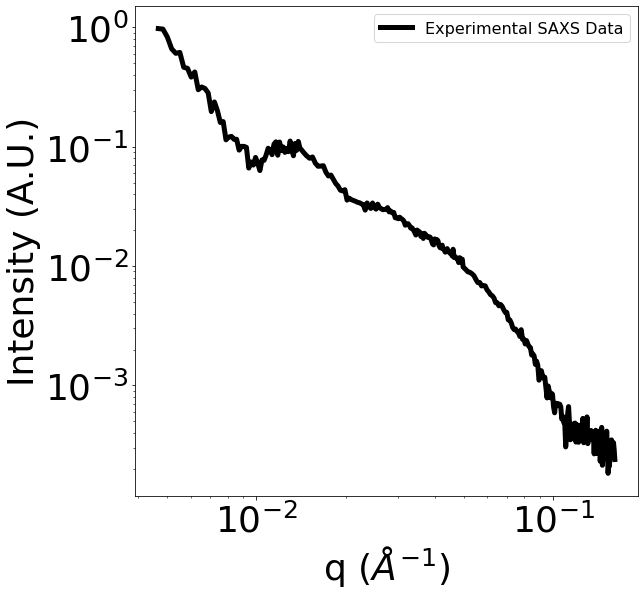

In [16]:
plt.subplots(figsize=(9,9))
plt.loglog(data[:,0], data[:,1]*6*10e-2, label = 'Experimental SAXS Data', linewidth = 5, color='k')
plt.ylabel('Intensity (A.U.)')
plt.xlabel('q ($\AA^{-1}$)')
plt.legend(fontsize=16)

The next step is to fit the experimental data with a weighted average of the simulated scattering curves of the models. The weights obtained represents the population distribution of each model in the sample. To find these weights, a genetic algorithm optimizer will be used to minimize the log mean squared error between the experimental data and the weighted average of the model scattering curves.  

A data processing step will be performed on each simulated data to ensure that all the scattering curves have the same number of data points. 

In [17]:
#Convert model to length of data 
def convert_data(data, model):
    model_x = model[:,0]
    model_y = model[:,1]
    index = np.linspace(0, len(model_x)-1, len(model_x)) 
    model_q_new = []
    model_I_new = []
    for i in range(len(data)):
        data_q = data[i,0]
        array = np.abs(model_x - data_q)
        array = np.hstack((array.reshape(-1,1), index.reshape(-1,1)))
        array = array[np.argsort(array[:, 0])]
        loc = int(array[0,1])
        model_q_new.append(model_x[loc])
        model_I_new.append(model_y[loc])
    q = np.array(model_q_new).reshape(-1,1)
    I = np.array(model_I_new).reshape(-1,1)
    new_model_data = np.hstack((q, I))
    return new_model_data

In [18]:
#Convert model to have the same size as data
model_0 = convert_data(data, model0)
model_1 = convert_data(data, model1)
model_2 = convert_data(data, model2)
model_3 = convert_data(data, model3)
model_4 = convert_data(data, model4)
model_5 = convert_data(data, model5)
model_6 = convert_data(data, model6)
model_7 = convert_data(data, model7)
model_8 = convert_data(data, model8)
model_9 = convert_data(data, model9)

Functions to use the genetic optimization code are prepared. 

In [19]:
def func(w0, w1, w2, w3, w4, w5, w6, w7, w8, w9, scale): #This will be our objective function 
    model_avg = (w0*model_0[:,1]*1000 + w1*model_1[:,1] + w2*model_2[:,1] + w3*model_3[:,1] + w4*model_4[:,1] + w5*model_5[:,1] + w6*model_6[:,1] + w7*model_7[:,1] + w8*model_8[:,1] + w9*model_9[:,1])
    background = 2.5*10e-4
    error = np.mean(np.abs(np.log10(data_y*((scale + 10e-10)*10e8) - background) - np.log10(model_avg)))
    return -error

def func_loop(x):
    for i in range(x.shape[0]): # This is a loop that runs the test function for each row of an array
        y_row = func(x[i,0], x[i,1], x[i,2], x[i,3], x[i,4], x[i,5], x[i,6], x[i,7], x[i,8], x[i,9], x[i,10]).reshape(1,-1)
        if i == 0:
            y = y_row
        else:
            y = np.vstack((y, y_row))
    return y

def overall_max(scores): # This creates a list of the cumulative best scores from the scores in a list
    all_max = [scores[0]]
    for i in range(len(scores)):
        if scores[i] > all_max[i]:
            all_max.append(scores[i])
        else:
            all_max.append(all_max[i])
    return all_max

def invariant(data):
    q = data[:,0]
    I = data[:,1]
    invariant = scipy.integrate.simps(q**2*I, q)
    return invariant

The code to run the genetic optmization. **Note:** if this code block gives an error, rerun it until it doesn't. The optimization algorithm is somewhat stochastic and depends on the initial random conditions. 

In [29]:
data_y = data[:,1]
batch_size = 500
x = np.random.rand(batch_size,11)
y = func_loop(x)
mutation_rate = 0.2
alg = GA.genetic_algorithm(batch_size, mutation_rate)

iterations = 500
for i in range(iterations):
    x = alg.run(x,y)
    y = func_loop(x)

In [45]:
w0 = alg.best_solution()[0]
w1 = alg.best_solution()[1]
w2 = alg.best_solution()[2]
w3 = alg.best_solution()[3]
w4 = alg.best_solution()[4]
w5 = alg.best_solution()[5]
w6 = alg.best_solution()[6]
w7 = alg.best_solution()[7]
w8 = alg.best_solution()[8]
w9 = alg.best_solution()[9]
scale = alg.best_solution()[10]
model_avg = w0*model_0[:,1]*1000 + w1*model_1[:,1] + w2*model_2[:,1] + w3*model_3[:,1] + w4*model_4[:,1] + w5*model_5[:,1] + w6*model_6[:,1] + w7*model_7[:,1] + w8*model_8[:,1] + w9*model_9[:,1]

From the genetic optimizaiton, the best weights for the weighted average were obtained. The model curve, which is composed of the weighted average using the best weights, is plotted with together with the experimental curve, and shows good agreement. 

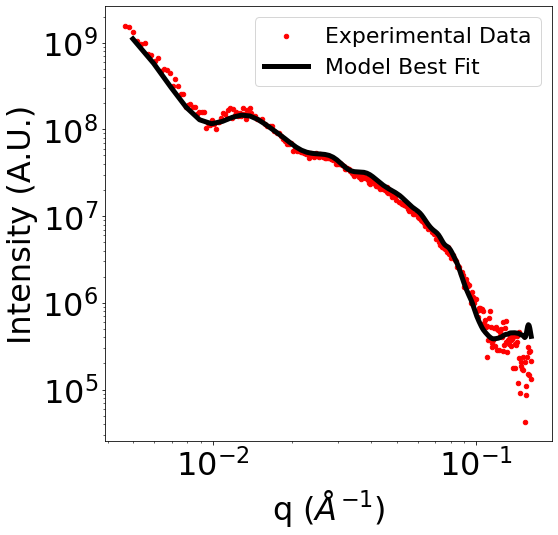

In [47]:
plt.rcParams.update({'font.size': 32})
plt.subplots(figsize=(8,8))
background = 2.5*10e4
plt.scatter(data[:,0], data[:,1]*((scale + 10e-10)*10e8) - background, label = 'Experimental Data', s = 20, color = 'red')
plt.loglog(model_1[:,0], model_avg, label = 'Model Best Fit', linewidth = 5, alpha = 1, color = 'k')
plt.legend(loc=1, prop={'size': 22})
plt.ylabel('Intensity (A.U.)')
plt.xlabel('q ($\AA^{-1}$)')
#plt.savefig('../Figures/Best_Fit.jpg', dpi=300, bbox_inches="tight")

The best weights can then be plotted to show the distribution of each tube diameter in the sample.

In [48]:
n_proteins = np.array([1, 196, 226, 256, 286, 316, 346, 376, 406, 436]).reshape(-1,1)
proportion_rhua_lst = []
for i in range(n_proteins.shape[0]):
    proportion_rhua = n_proteins[i][0]*alg.best_solution()[i]
    proportion_rhua_lst.append(proportion_rhua)
prop = np.array(proportion_rhua_lst)
prop[0] = prop[0]*1000

Text(0, 0.5, 'Frequency')

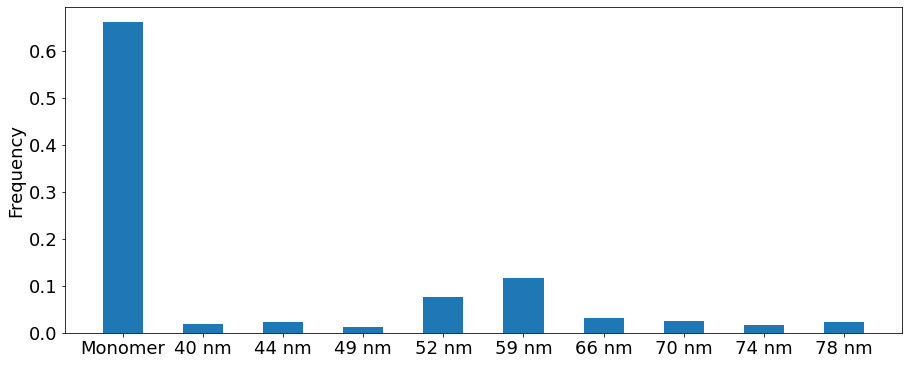

In [49]:
plt.rcParams.update({'font.size': 18})
plt.subplots(figsize=(15,6))
keys = ['Monomer','40 nm', '44 nm', '49 nm','52 nm','59 nm','66 nm', '70 nm', '74 nm','78 nm']
plt.bar(keys, prop/np.sum(prop), width= 0.5)
plt.ylabel('Frequency')
#plt.savefig('../Figures/Fitting/Histogram_RhuA_Assembly_large_font.jpg', dpi=500, bbox_inches="tight")

Plotting without the monomer

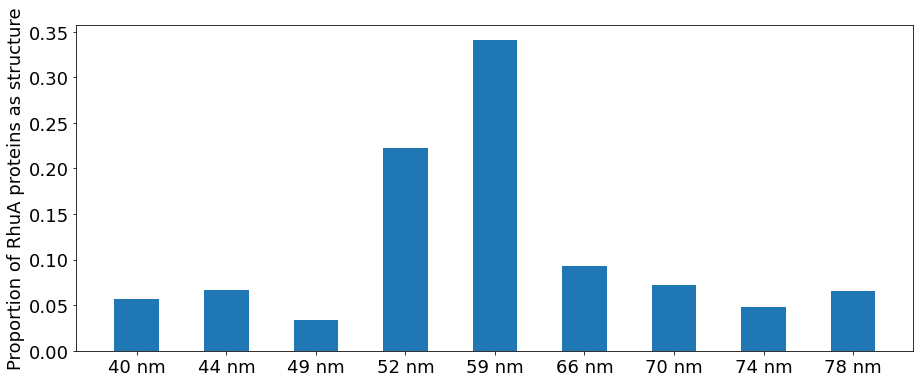

In [50]:
plt.subplots(figsize=(15,6))
plt.rcParams.update({'font.size': 12})
keys = ['40 nm', '44 nm', '49 nm','52 nm','59 nm','66 nm', '70 nm', '74 nm','78 nm']
plt.bar(keys, prop[1:]/np.sum(prop[1:]), width= 0.5)
plt.ylabel('Proportion of RhuA proteins as structure')
#plt.savefig('../Figures/Histogram_RhuA_Assembly.jpg', dpi=300, bbox_inches="tight")